In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import os
from funciones_auxiliares import *
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.metrics import r2_score
from xgboost import XGBRegressor
import matplotlib.pyplot as plt
from statistics import median, mode
import warnings
warnings.filterwarnings('ignore')

# 5.4 Selección de los mejores quintetos

Como segundo objetivo del Trabajo Fin de Máster, ha sido definido la *selección de los mejores quintentos* de jugadores a patir de las nuevas posiciones definidas mientras la aplicación de la clusterización. Para ello, durante este apartado será realizada esa selección de quintetos mediante la implementación de un modelo de regresión con el cual se espera obtener un rating que permita clasificar cada uno de los quintetos existentes en la liga. Para la realización de la *selección de mejores quinteto*. en este notebook, se abordarán los siguientes apartados:
* **1. Preparación de los datos.** Mediante la *Estadísticas totales de quintetos* y la nuevas posiciones definidas se realizará la selección de estadísticas que serán utilizadas para la creación del conjunto de datos que será incluido en el modelo de regresión.
* **2. Selección del modelo de regresión.** Se realizará la ejecución de distintos modelos de regresión para obtener los mejores hiperparámetros y modelo que mejor se ajusten al conjunto de datos.
* **3. Entrenamineto y predicción.** Se realizará el entrenamiento del modelo con los hiperparámetros seleccionados, y se realizará la predicción para obtención de rating de clasicicación del modelo.
* **4. Análisis de resultados.** Se realizará el análisis de los resultados obtenidos tras las predicción sobre el conjunto de datos y se obtendrá los mejores quintetos con las nuevas posiciones.

A través de estos paso se espera por un lado obtener las nuevas posiciones y que se entienda todo el proceso implementado para su obtención.

## 1. Preparación de los datos.

Dentro de la preparación de los datos, como se ha comentado en el apartado anterior, será necesario hacer uso de las *Estadísticas totales de los quintetos* y de las *Nuevas posiciones definidas*. Es por este motivo, que se realiza la carga de ambos tipos de información:

In [2]:
# Ruta de clustering
ruta_clustering = 'E:/TFM/02. Datos/ACB/CLUSTERING'
df_tablon_control = pd.read_csv(ruta_clustering + '/' + '01_CLUSTERING_PLAYERS_KMEANS.csv', sep=';')
df_tablon_control = df_tablon_control[['TEMPORADA', 'EQUIPO', 'JUGADOR_PBP', 'CLUSTER']]

# Ruta de estadísticas
ruta_estadisticas = 'E:/TFM/02. Datos/ACB/ESTADISTICAS'
df_estadisticas_quinteto = pd.DataFrame()
l_dir_temporadas = ['2020', '2021', '2022']

for temporada in l_dir_temporadas:
    # Se extrae el listado de directorios de equipos
    ruta_dir_temporada = ruta_estadisticas + '/' + temporada
    l_dir_equipos = os.listdir(ruta_dir_temporada)
    
    for equipo in l_dir_equipos:
        # Se inicializa la ruta de estadísticas de un equipo
        ruta_dir_estadisticas_equipo = ruta_dir_temporada + '/' + equipo
        
        # Se realiza la carga de ficheros de estadísticas de jugadores
        df_estadisticas_quinteto_equipo = pd.read_csv(ruta_dir_estadisticas_equipo + '/03_ESTADISTICAS_QUINTETO_EQUIPO.csv', sep = ';')
        df_estadisticas_quinteto_equipo['TEMPORADA'] = int(temporada)
        df_estadisticas_quinteto = pd.concat([df_estadisticas_quinteto,df_estadisticas_quinteto_equipo])

print("#######################################")
print("# NUEVAS POSICIONES DEFINIDAS")
print("#######################################")
print(df_tablon_control.head().to_string(index=False, col_space=4))

print("\n#######################################")
print("# ESTADISTICAS TOTALES DE QUINTETOS")
print("#######################################")
print(df_estadisticas_quinteto.head().to_string(index=False, col_space=4))

#######################################
# NUEVAS POSICIONES DEFINIDAS
#######################################
 TEMPORADA     EQUIPO JUGADOR_PBP  CLUSTER
      2020 Acunsa GBC         Dee        3
      2020 Acunsa GBC       Okouo        4
      2020 Acunsa GBC    Faggiano        3
      2020 Acunsa GBC     Carlson        1
      2020 Acunsa GBC        Span        1

#######################################
# ESTADISTICAS TOTALES DE QUINTETOS
#######################################
    EQUIPO      J1   J2        J3       J4       J5  T2A  T2L  T3A  T3L  TLA  TLL   RO   RD  STL  TOV  AST  BLK  T2A_R  T2L_R  T3A_R  T3L_R  TLA_R  TLL_R  RO_R  RD_R  STL_R  TOV_R  AST_R  BLK_R  TIEMPO_PISTA  TEMPORADA
Acunsa GBC Carlson  Dee Echenique Radoncic     Span    1    1    0    1    0    0    0    1    0    0    0    0      1      1      1      2      1      4     2     1      0      0      1      0            96       2020
Acunsa GBC Carlson  Dee  Faggiano Magarity    Motos    4    9    3    4    1 

Como puede observarse, se ha realizado la carga por un lado de la información de cada jugador junto a la nueva posición que se le ha sido asignada y por otro lado se ha realizado la carga de las estadísticas totales para cada uno de los quintetos. Tras la realización de este paso, se realiza la sustitución dentro del conjunto de datos de cada jugador por la posición que se le ha sido asignada además de ordenar cada una de las posiciones de manera ascendente para las futuras agrupaciones que se realizarán:

In [3]:
# Se sustituye cada uno de los jugadores por la nueva posiciön en la que ha sido agrupada
df_estadisticas_quinteto_aux = df_estadisticas_quinteto.merge(df_tablon_control, left_on=['TEMPORADA','EQUIPO','J1'], right_on=['TEMPORADA','EQUIPO','JUGADOR_PBP']).drop('JUGADOR_PBP',axis=1).rename(columns={'CLUSTER':'J1_CLUSTER'})
df_estadisticas_quinteto_aux = df_estadisticas_quinteto_aux.merge(df_tablon_control, left_on=['TEMPORADA','EQUIPO','J2'], right_on=['TEMPORADA','EQUIPO','JUGADOR_PBP']).drop('JUGADOR_PBP',axis=1).rename(columns={'CLUSTER':'J2_CLUSTER'})
df_estadisticas_quinteto_aux = df_estadisticas_quinteto_aux.merge(df_tablon_control, left_on=['TEMPORADA','EQUIPO','J3'], right_on=['TEMPORADA','EQUIPO','JUGADOR_PBP']).drop('JUGADOR_PBP',axis=1).rename(columns={'CLUSTER':'J3_CLUSTER'})
df_estadisticas_quinteto_aux = df_estadisticas_quinteto_aux.merge(df_tablon_control, left_on=['TEMPORADA','EQUIPO','J4'], right_on=['TEMPORADA','EQUIPO','JUGADOR_PBP']).drop('JUGADOR_PBP',axis=1).rename(columns={'CLUSTER':'J4_CLUSTER'})
df_estadisticas_quinteto_aux = df_estadisticas_quinteto_aux.merge(df_tablon_control, left_on=['TEMPORADA','EQUIPO','J5'], right_on=['TEMPORADA','EQUIPO','JUGADOR_PBP']).drop('JUGADOR_PBP',axis=1).rename(columns={'CLUSTER':'J5_CLUSTER'})

# Se ordenan las agrupaciones según el cluster
df_estadisticas_quinteto_aux['J1_CLUSTER_ORDERED'] = ''
df_estadisticas_quinteto_aux['J2_CLUSTER_ORDERED'] = ''
df_estadisticas_quinteto_aux['J3_CLUSTER_ORDERED'] = ''
df_estadisticas_quinteto_aux['J4_CLUSTER_ORDERED'] = ''
df_estadisticas_quinteto_aux['J5_CLUSTER_ORDERED'] = ''

for index, row in df_estadisticas_quinteto_aux.iterrows():
    l_clusters = sorted([row['J1_CLUSTER'], row['J2_CLUSTER'], row['J3_CLUSTER'], row['J4_CLUSTER'], row['J5_CLUSTER']])
    df_estadisticas_quinteto_aux.at[index,'J1_CLUSTER_ORDERED'] = l_clusters[0]
    df_estadisticas_quinteto_aux.at[index,'J2_CLUSTER_ORDERED'] = l_clusters[1]
    df_estadisticas_quinteto_aux.at[index,'J3_CLUSTER_ORDERED'] = l_clusters[2]
    df_estadisticas_quinteto_aux.at[index,'J4_CLUSTER_ORDERED'] = l_clusters[3]
    df_estadisticas_quinteto_aux.at[index,'J5_CLUSTER_ORDERED'] = l_clusters[4]


# Se realiza la selección de variables final con las que se trabajará
df_estadisticas_quinteto_cluster = df_estadisticas_quinteto_aux[['TEMPORADA','EQUIPO','J1_CLUSTER_ORDERED', 'J2_CLUSTER_ORDERED', 'J3_CLUSTER_ORDERED','J4_CLUSTER_ORDERED', 'J5_CLUSTER_ORDERED', 'T2A', 'T2L', 'T3A', 'T3L', 'TLA', 'TLL', 'RO', 'RD', 'STL', 'TOV', 'AST', 'BLK', 'T2A_R', 'T2L_R', 'T3A_R', 'T3L_R', 'TLA_R', 'TLL_R', 'RO_R', 'RD_R', 'STL_R', 'TOV_R', 'AST_R', 'BLK_R', 'TIEMPO_PISTA']]    
print("####################################################")
print("# ESTADISTICAS TOTALES DE QUINTETOS CLUSTERIZADAS")
print("####################################################")
print(df_estadisticas_quinteto_cluster.head().to_string(index=False, col_space=1))

####################################################
# ESTADISTICAS TOTALES DE QUINTETOS CLUSTERIZADAS
####################################################
 TEMPORADA     EQUIPO J1_CLUSTER_ORDERED J2_CLUSTER_ORDERED J3_CLUSTER_ORDERED J4_CLUSTER_ORDERED J5_CLUSTER_ORDERED  T2A  T2L  T3A  T3L  TLA  TLL  RO  RD  STL  TOV  AST  BLK  T2A_R  T2L_R  T3A_R  T3L_R  TLA_R  TLL_R  RO_R  RD_R  STL_R  TOV_R  AST_R  BLK_R  TIEMPO_PISTA
      2020 Acunsa GBC                  1                  1                  2                  3                  5    1    1    0    1    0    0   0   1    0    0    0    0      1      1      1      2      1      4     2     1      0      0      1      0            96
      2020 Acunsa GBC                  1                  2                  3                  3                  5    4    6    4    5   10   11   3   2    5    4    4    0      4      7      4      8      2      2     3     2      1      7      5      0           556
      2020 Acunsa GBC          

Como puede observarse, tras la sustitución de los nombres de los jugadores por los clusters a los que pertenecen y su ordenación, se obtiene como resultado un cojunto de datos en los que cada uno de los quintetos jugadores en cada uno de los equipos para cada una de las temporadas en el que los jugadores están representados por los clusters a los que pertenecen. Tras esto se va a proceder a la agrupación del conjunto de datos en dos conjuntos de datos diferentes:
* *Conjunto de datos de entrenamiento.* En este conjunto de datos, se realizará la agrupación de las estadísticas teniendo en cuenta la temporada, el equipo y los tipos de posiciones que se encuentran dentro del quinteto. Con esta agrupación, se construye el conjunto de datos que serán utilizado para el entrenamiento y la selección del modelo respetando el contexto en el que se desarrolló el quinteto debido a que no todos los equipos juegan de la misma manera.
* *Conjunto de datos para la predicción.* En este conjunto de datos, se realizará la agrupación de las estadístias teniendo en cuenta únicamente los tipos de posiciones que se encuentran en el quinteto. Con esta agrupación, se contruye el conjunto de datos sobre el que se realizará la predicción y con el que se obtendrá cual es el tipo de quinteto que obtiene mejores resultados dentro de la liga.

Dicho esto, se pasa a la construcción de ambos cojuntos de datos:

In [4]:
# Se realiza la agrupación por temporada, equipo y tipos de jugadores
df_estadisticas_quinteto_grouped =  df_estadisticas_quinteto_cluster.groupby(['TEMPORADA','EQUIPO','J1_CLUSTER_ORDERED', 'J2_CLUSTER_ORDERED', 'J3_CLUSTER_ORDERED','J4_CLUSTER_ORDERED', 'J5_CLUSTER_ORDERED']).sum().reset_index()
print("####################################################")
print("# CONJUNTOS DE DATOS DE ENTRENAMIENTO")
print("####################################################")
print("Nº de registros:",len(df_estadisticas_quinteto_cluster))
print("Nº de variables:",len(df_estadisticas_quinteto_cluster.columns))
print(df_estadisticas_quinteto_cluster.head().to_string(index=False, col_space=1))


# Se realiza la agrupación por tipos de jugadores
df_estadisticas_total_quinteto_cluster = df_estadisticas_quinteto_aux[['J1_CLUSTER_ORDERED', 'J2_CLUSTER_ORDERED', 'J3_CLUSTER_ORDERED','J4_CLUSTER_ORDERED', 'J5_CLUSTER_ORDERED', 'T2A', 'T2L', 'T3A', 'T3L', 'TLA', 'TLL', 'RO', 'RD', 'STL', 'TOV', 'AST', 'BLK', 'T2A_R', 'T2L_R', 'T3A_R', 'T3L_R', 'TLA_R', 'TLL_R', 'RO_R', 'RD_R', 'STL_R', 'TOV_R', 'AST_R', 'BLK_R', 'TIEMPO_PISTA']]    
df_estadisticas_total_quinteto_grouped =  df_estadisticas_total_quinteto_cluster.groupby(['J1_CLUSTER_ORDERED', 'J2_CLUSTER_ORDERED', 'J3_CLUSTER_ORDERED','J4_CLUSTER_ORDERED', 'J5_CLUSTER_ORDERED']).sum().reset_index()

print("\n####################################################")
print("# CONJUNTOS DE DATOS DE PREDICCIÓN")
print("####################################################")
print("Nº de registros:",len(df_estadisticas_total_quinteto_grouped))
print("Nº de variables:",len(df_estadisticas_total_quinteto_grouped.columns))
print(df_estadisticas_total_quinteto_grouped.head().to_string(index=False, col_space=1))

####################################################
# CONJUNTOS DE DATOS DE ENTRENAMIENTO
####################################################
Nº de registros: 13885
Nº de variables: 32
 TEMPORADA     EQUIPO J1_CLUSTER_ORDERED J2_CLUSTER_ORDERED J3_CLUSTER_ORDERED J4_CLUSTER_ORDERED J5_CLUSTER_ORDERED  T2A  T2L  T3A  T3L  TLA  TLL  RO  RD  STL  TOV  AST  BLK  T2A_R  T2L_R  T3A_R  T3L_R  TLA_R  TLL_R  RO_R  RD_R  STL_R  TOV_R  AST_R  BLK_R  TIEMPO_PISTA
      2020 Acunsa GBC                  1                  1                  2                  3                  5    1    1    0    1    0    0   0   1    0    0    0    0      1      1      1      2      1      4     2     1      0      0      1      0            96
      2020 Acunsa GBC                  1                  2                  3                  3                  5    4    6    4    5   10   11   3   2    5    4    4    0      4      7      4      8      2      2     3     2      1      7      5      0           556


Tras la creación de ambos conjuntos de datos, y como último paso dentro de la preparación de los datos, se realizará la construcción de las estadísticas avanzadas para cada uno de los quintetos que serán utilizadas para las construcción de los conjuntos de datos finales y que estarán formados por las siguiente estadísticas:
* *POSS.* Refleja el número de posesiones que realizó el quinteto y que será utilizada para el filtrado de quintetos con poca participación dentro de la liga.
* *OER.* Refleja la eficiencia ofensiva del quinteto y será utilizada para la construcción de la variable a predecir.
* *DER.* Refleja la eficiencia defensiva del quinteto y será utilizada para la construcción de la variable a predecir.
* *NET.* Refleja la diferencia entre eficiencia ofensiva y defensiva. Esta variable será la variable a predecir por los modelos de regresión.
* *eFG%.* Refleja la eficiencia en el tiro del quinteto.
* *RO%.* Refleja el volumen de rebotes ofensivos capturados por el quinteto cuando este estuvo en la pista.
* *FT%.* Refleja el nivel de verticalidad del quinteto cuando este estuvo en la pista.
* *TOV%.* Refleha el volumen de acciones que terminaron en pérdida por el quinteto cuando este estuvo en pista.
* *eFG%_R.* Refleja la eficiencia en el tiro del quinteto rival.
* *RO%_R.* Refleja el volumen de rebotes ofensivos capturados por el quinteto rival.
* *FT%_R.* Refleja el nivel de verticalidad del quinteto rival.
* *TOV%_R.* Refleha el volumen de acciones que terminaron en pérdida por el quinteto rival.

Mediante estas estadísticas avanzadas se construirá el conjunto de datos final tanto de entrenamiento como de predicción.

In [5]:
# Se realiza la creación del conjunto de datos de entrenamiento
df_quintetos_avanzada_grouped = df_estadisticas_quinteto_grouped[['TEMPORADA','EQUIPO','J1_CLUSTER_ORDERED', 'J2_CLUSTER_ORDERED', 'J3_CLUSTER_ORDERED','J4_CLUSTER_ORDERED', 'J5_CLUSTER_ORDERED']]
df_quintetos_avanzada_grouped['POSS'] = obtener_poss(df_estadisticas_quinteto_grouped).fillna(0).round(4)
df_quintetos_avanzada_grouped['OER'] = obtener_oer(df_estadisticas_quinteto_grouped).fillna(0).round(4)
df_quintetos_avanzada_grouped['DER'] = obtener_der(df_estadisticas_quinteto_grouped).fillna(0).round(4)
df_quintetos_avanzada_grouped['NET'] = df_quintetos_avanzada_grouped['OER'] - df_quintetos_avanzada_grouped['DER']
df_quintetos_avanzada_grouped['eFG%'] = obtener_eFGp(df_estadisticas_quinteto_grouped).fillna(0).round(4)
df_quintetos_avanzada_grouped['RO%'] = obtener_ROp(df_estadisticas_quinteto_grouped).fillna(0).round(4)
df_quintetos_avanzada_grouped['FT%'] = obtener_FTp(df_estadisticas_quinteto_grouped).fillna(0).round(4)
df_quintetos_avanzada_grouped['TOV%'] = obtener_tovp(df_estadisticas_quinteto_grouped).fillna(0).round(4)
df_quintetos_avanzada_grouped['eFG%_R'] = obtener_eFGp_rival(df_estadisticas_quinteto_grouped).fillna(0).round(4)
df_quintetos_avanzada_grouped['RO%_R'] = obtener_ROp_rival(df_estadisticas_quinteto_grouped).fillna(0).round(4)
df_quintetos_avanzada_grouped['FT%_R'] = obtener_FTp_rival(df_estadisticas_quinteto_grouped).fillna(0).round(4)
df_quintetos_avanzada_grouped['TOV%_R'] = obtener_tovp_rival(df_estadisticas_quinteto_grouped).fillna(0).round(4)

# Se realiza la creación del conjuno de datos de predicción
df_quintetos_avanzada_total_grouped = df_estadisticas_total_quinteto_grouped[['J1_CLUSTER_ORDERED', 'J2_CLUSTER_ORDERED', 'J3_CLUSTER_ORDERED','J4_CLUSTER_ORDERED', 'J5_CLUSTER_ORDERED']]
df_quintetos_avanzada_total_grouped['POSS'] = obtener_poss(df_estadisticas_total_quinteto_grouped).fillna(0).round(4)
df_quintetos_avanzada_total_grouped['OER'] = obtener_oer(df_estadisticas_total_quinteto_grouped).fillna(0).round(4)
df_quintetos_avanzada_total_grouped['DER'] = obtener_der(df_estadisticas_total_quinteto_grouped).fillna(0).round(4)
df_quintetos_avanzada_total_grouped['NET'] = df_quintetos_avanzada_total_grouped['OER'] - df_quintetos_avanzada_total_grouped['DER']
df_quintetos_avanzada_total_grouped['eFG%'] = obtener_eFGp(df_estadisticas_total_quinteto_grouped).fillna(0).round(4)
df_quintetos_avanzada_total_grouped['RO%'] = obtener_ROp(df_estadisticas_total_quinteto_grouped).fillna(0).round(4)
df_quintetos_avanzada_total_grouped['FT%'] = obtener_FTp(df_estadisticas_total_quinteto_grouped).fillna(0).round(4)
df_quintetos_avanzada_total_grouped['TOV%'] = obtener_tovp(df_estadisticas_total_quinteto_grouped).fillna(0).round(4)
df_quintetos_avanzada_total_grouped['eFG%_R'] = obtener_eFGp_rival(df_estadisticas_total_quinteto_grouped).fillna(0).round(4)
df_quintetos_avanzada_total_grouped['RO%_R'] = obtener_ROp_rival(df_estadisticas_total_quinteto_grouped).fillna(0).round(4)
df_quintetos_avanzada_total_grouped['FT%_R'] = obtener_FTp_rival(df_estadisticas_total_quinteto_grouped).fillna(0).round(4)
df_quintetos_avanzada_total_grouped['TOV%_R'] = obtener_tovp_rival(df_estadisticas_total_quinteto_grouped).fillna(0).round(4)

print("####################################################")
print("# CONJUNTOS DE DATOS DE ENTRENAMIENTO")
print("####################################################")
print("Nº de registros:",len(df_quintetos_avanzada_grouped))
print("Nº de variables:",len(df_quintetos_avanzada_grouped.columns))
print(df_quintetos_avanzada_grouped.head().to_string(index=False, col_space=1))

print("\n####################################################")
print("# CONJUNTOS DE DATOS DE PREDICCIÓN")
print("####################################################")
print("Nº de registros:",len(df_quintetos_avanzada_total_grouped))
print("Nº de variables:",len(df_quintetos_avanzada_total_grouped.columns))
print(df_quintetos_avanzada_total_grouped.head().to_string(index=False, col_space=1))


####################################################
# CONJUNTOS DE DATOS DE ENTRENAMIENTO
####################################################
Nº de registros: 2297
Nº de variables: 19
 TEMPORADA     EQUIPO  J1_CLUSTER_ORDERED  J2_CLUSTER_ORDERED  J3_CLUSTER_ORDERED  J4_CLUSTER_ORDERED  J5_CLUSTER_ORDERED  POSS    OER    DER     NET   eFG%    RO%   FT%   TOV%  eFG%_R  RO%_R  FT%_R  TOV%_R
      2020 Acunsa GBC                   1                   1                   1                   1                   2  9.00 0.5556 1.0000 -0.4444 0.2500 0.2500 0.000 0.0909  0.5000 0.2500 0.1250  0.1838
      2020 Acunsa GBC                   1                   1                   1                   1                   3 62.52 0.9437 1.0397 -0.0960 0.4417 0.2105 0.100 0.0993  0.6170 0.2381 0.1489  0.1469
      2020 Acunsa GBC                   1                   1                   1                   2                   3 59.72 1.1219 1.1721 -0.0502 0.5192 0.3846 0.250 0.1721  0.7143 0.3333 0

Para finalizar, se realiza la limpieza de ambos conjutos de datos seleccionando aquellos registros en los que los quintetos hayan jugado al menos un total de 40 posesiones para que no existan quintetos que tengan valores altamente positivo o negativos por el haber jugado posesiones casi residuales. Además se seleccionan únicamente las variables que se incluirán en el entrenamiento y la variable predictora: 

In [6]:
# Filtrado de ambos conjuntos de datos por 20 posesiones
df_quintetos_avanzada_grouped = df_quintetos_avanzada_grouped[df_quintetos_avanzada_grouped['POSS'] >= 40]
df_quintetos_avanzada_total_grouped = df_quintetos_avanzada_total_grouped[df_quintetos_avanzada_total_grouped['POSS'] >= 40]

# Selección de variables
df_quintetos_avanzada_grouped = df_quintetos_avanzada_grouped[[ 'J1_CLUSTER_ORDERED', 'J2_CLUSTER_ORDERED','J3_CLUSTER_ORDERED', 'J4_CLUSTER_ORDERED', 'J5_CLUSTER_ORDERED','eFG%', 'RO%', 'FT%','TOV%', 'eFG%_R', 'RO%_R', 'FT%_R', 'TOV%_R','NET']]
df_quintetos_avanzada_total_grouped = df_quintetos_avanzada_total_grouped[[ 'J1_CLUSTER_ORDERED', 'J2_CLUSTER_ORDERED','J3_CLUSTER_ORDERED', 'J4_CLUSTER_ORDERED', 'J5_CLUSTER_ORDERED','eFG%', 'RO%', 'FT%','TOV%', 'eFG%_R', 'RO%_R', 'FT%_R', 'TOV%_R','NET']]

print("####################################################")
print("# CONJUNTOS DE DATOS DE ENTRENAMIENTO")
print("####################################################")
print("Nº de registros:",len(df_quintetos_avanzada_grouped))
print("Nº de variables:",len(df_quintetos_avanzada_grouped.columns))
print(df_quintetos_avanzada_grouped.head().to_string(index=False, col_space=1))

print("\n####################################################")
print("# CONJUNTOS DE DATOS DE PREDICCIÓN")
print("####################################################")
print("Nº de registros:",len(df_quintetos_avanzada_total_grouped))
print("Nº de variables:",len(df_quintetos_avanzada_total_grouped.columns))
print(df_quintetos_avanzada_total_grouped.head().to_string(index=False, col_space=1))

####################################################
# CONJUNTOS DE DATOS DE ENTRENAMIENTO
####################################################
Nº de registros: 797
Nº de variables: 14
 J1_CLUSTER_ORDERED  J2_CLUSTER_ORDERED  J3_CLUSTER_ORDERED  J4_CLUSTER_ORDERED  J5_CLUSTER_ORDERED   eFG%    RO%    FT%   TOV%  eFG%_R  RO%_R  FT%_R  TOV%_R     NET
                  1                   1                   1                   1                   3 0.4417 0.2105 0.1000 0.0993  0.6170 0.2381 0.1489  0.1469 -0.0960
                  1                   1                   1                   2                   3 0.5192 0.3846 0.2500 0.1721  0.7143 0.3333 0.2381  0.2375 -0.0502
                  1                   1                   1                   3                   4 0.5167 0.2838 0.1250 0.1489  0.5427 0.4127 0.1282  0.1873 -0.0224
                  1                   1                   1                   3                   5 0.4732 0.2105 0.0893 0.0898  0.4912 0.3103 0.1404  

Tras la finalización de la preparación de variables, se obtienen dos conjuntos de datos uno que será utilizado para el entrenamiento del modelo de regresión y otro que será utilizado para la obtención de los mejores quinteto.

## 2. Selección del modelo de regresión.

Como se ha comentado al inicio del notebook ha sido decidido que, para la selección de los mejores quintetos conformados por la nuevas posiciones, se realice la implementación de un algoritmo de regresión debido a que mediante este tipo de algoritmo se puede realizar la predicción de una variable numérica lo que permitirá obtención de *rating* que permita clasificar a los equipos en función diferentes caracteristicas que permitan definir a los quintetos. Es por este motivo que como primer paso dentro de esta implementación, se realizará la evaluación de diferentes modelos de regresión que permitan ajustarse al conjunto de datos de entrenamiento anteriormente construido.

Para esta evaluación, en primer lugar, se realizará la ejecución de 4 algoritmos de regresión en los que se buscarán los mejores hiperparámetros para cada uno de ellos mediante el método de validación cruzada. Estos algoritmos de regresión son los siguientes:
* *Regresión lineal.* Es uno de los algoritmos de aprendizaje automático más simples y utilizados en regresión debido a que busca minimizar la suma de los errores cuadrados entre las predicciones del modelo y los valores reales.
* *Random forest.* Es un algortimo de aprendizaje automático basado en arboles de decisión en donde, el modelo, construye múltiples árboles de decisión durante el entrenamiento y emite la media de las predicciones de los árboles individuales para obtener una predicción más precisa y robusta.
* *SVR lineal.* Es un algoritmo de aprendizaje automático basado en las máquinas de soporte vectorial. Este algoritmo intenta encontrar un hiperplano en un espacio de alta dimensión que minimiza el error de la predcción, a la vez que se asegura de que las desviaciones de las predicciones estén dentro de un margen tolerable.
* *XGBoost.* Es un método de aprendzaje supervisado que combina las predicciones de múltiples modelos más simples para mejorar la precisión.

Como entrada a los anteriores modelos definidos, y como se ha nombrado anteriormente, se hará uso del conjunto de datos de entrenamiento que ha sido construido en el apartado anterior. Este conjunto de datos, será divido en dos subdonjutos de variables:
* *Variables predictoras.* Ha sido seleccionadas las variables J1_CLUSTER_ORDERED, J2_CLUSTER_ORDERED, J3_CLUSTER_ORDERED, J4_CLUSTER_ORDERED y J5_CLUSTER_ORDERED que representarán las nuevas posiciones de jugadores de baloncesto y las variables eFG%, RO%, FT%, TOV%, eFG%_R, RO%_R, FT%_R y TOV%_R que representarán el desempeño del quinteto y de sus rivales el tiempo que estuvieron en pista.
* *Variable a predecir.* Ha sido seleccionada la variable *NET* que es la variable que permite conocer el rendimiento de un quinteto a través de la diferencia del rendimiento ofensivo y defensivo del quinteto.

Dicho esto se pasa a la construcción de los datos de entrada de los modelos, los cuales serán divididos en conjunto de entrenamiento y test para evaluar cual de los modelos es el que mejor se ajusta a los datos:

In [7]:
# División de variables predictoras y variable a predecir
X = df_quintetos_avanzada_grouped.drop('NET', axis=1)
y = df_quintetos_avanzada_grouped['NET']

# División en datos de entrenamiento y text
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

Tras la división del conjunto de datos, se pasa a la evaluación de cada uno de los modelos. Para esta evaluación se ha decidido utilizar el coeficiente de determinación (R²), que es una medida estadística que indica la proporción de la variabilidad de la variable dependiente que es explicada por las variables independientes en el modelo en el rango de 0 a 1. Se pasa a la hiperametrización de cada uno de los modelos: 

### 2.1 Regresión lineal

In [8]:
# Inicialización del modelo e hiperametrización
model = LinearRegression()
param_grid = {'fit_intercept': [True, False], 'positive': [True, False], 'n_jobs':  [1,2,3,4,5,6,7,8,9,10]}

# Obtención de mejores hiperparámetros
grid_search = GridSearchCV(model, param_grid, cv=5, scoring='r2')
grid_search.fit(X_train, y_train)
best_params = grid_search.best_params_
print("Mejores hiperparámetros encontrados:", best_params)

# Obtención de resultados con los mejores hiperparámetros
best_model = grid_search.best_estimator_
score = best_model.score(X_test, y_test)
print("Coeficiente de determinación (R^2) del modelo:", score)

Mejores hiperparámetros encontrados: {'fit_intercept': True, 'n_jobs': 1, 'positive': False}
Coeficiente de determinación (R^2) del modelo: 0.9106143574397704


### 2.2 Random forest

In [9]:
# Inicialización del modelo e hiperametrización
model = RandomForestRegressor(random_state=42)
param_grid = {'n_estimators': [50, 100, 200], 'max_depth': [None, 10, 20], 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 2, 4]}

# Obtención de mejores hiperparámetros
grid_search = GridSearchCV(model, param_grid, cv=5, scoring='r2')
grid_search.fit(X_train, y_train)
best_params = grid_search.best_params_
print("Mejores hiperparámetros encontrados:", best_params)

# Obtención de resultados con los mejores hiperparámetros
best_model = grid_search.best_estimator_
score = best_model.score(X_test, y_test)
print("Coeficiente de determinación (R^2) del modelo:", score)

Mejores hiperparámetros encontrados: {'max_depth': 20, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}
Coeficiente de determinación (R^2) del modelo: 0.805981331715861


### 2.3 SVR lineal

In [10]:
# Inicialización del modelo e hiperametrización
model = SVR(kernel='linear')
param_grid = {'C': [0.1, 1, 10], 'gamma': ['scale', 'auto', 0.1, 1], 'epsilon': [0.01, 0.1, 0.5, 1.0]}

# Obtención de mejores hiperparámetros
grid_search = GridSearchCV(model, param_grid, cv=5, scoring='r2')
grid_search.fit(X_train, y_train)
best_params = grid_search.best_params_
print("Mejores hiperparámetros encontrados:", best_params)

# Obtención de resultados con los mejores hiperparámetros
best_model = grid_search.best_estimator_
score = best_model.score(X_test, y_test)
print("Coeficiente de determinación (R^2) del modelo:", score)


Mejores hiperparámetros encontrados: {'C': 10, 'epsilon': 0.01, 'gamma': 'scale'}
Coeficiente de determinación (R^2) del modelo: 0.9127831129849127


### 2.4 XGBoost

In [11]:
# Inicialización del modelo e hiperametrización
model = XGBRegressor(random_state=42)
param_grid = {'n_estimators': [100, 200, 300],'max_depth': [3, 4, 5],'learning_rate': [0.1, 0.01, 0.001]}

# Obtención de mejores hiperparámetros
grid_search = GridSearchCV(model, param_grid, cv=5, scoring='r2')
grid_search.fit(X_train, y_train)
best_params = grid_search.best_params_
print("Mejores hiperparámetros encontrados:", best_params)

# Obtención de resultados con los mejores hiperparámetros
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)
r2 = r2_score(y_test, y_pred)
print("Coeficiente de determinación (R^2) del modelo:", r2)

Mejores hiperparámetros encontrados: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 300}
Coeficiente de determinación (R^2) del modelo: 0.8631282005902833


### 2.5 Selección del mejor modelo

Tras la ejecución de los 4 modelos definidos junto a su hiperparametrización, se puede observar como todos los modelos han obtenido un *coeficiente de determinación* superior al 0.7 lo cual muestra que durante la hiperparametrización se han encontrado hiperparametros que se ajustan bien a los datos. Teniendo esto presente, los *coeficientes de determinación* se obtienen con el modelo de *Regresión lineal* y con el modelo *SVR lineal* dando unos valores de 0.910 y de 0.912 respectivamente. Debido a que las diferencias entre ambos resultados no son muy significativas y poniendo por delante la complejidad de los modelos, ha sido decidido que el modelo utilizado para la selección de los mejores quintetos sea el **SVR lineal** debido a que, como se ha comentado anteriormente, este modelo tiene una capacidad robusta para manejar datos de alta dimensionalidad y es menos susceptible a la multicolinealidad entre las variables independientes, lo que puede llevar a mejores resultados en escenarios más complejos.

## 3. Entrenamineto y predicción.

Tras la selección del modelo *SVR Lineal* como el escogido para realizar la búsqueda de los mejores quintetos, se pasa a realizar el entrenamiento de este y la predicción del *rating* que permita obtener estos quintetos. Con respecto al entrenamiento, ha sido decidido realizarlo con todos los quintetos utilizados por cada uno de los equipos a lo largo de una temporada teniendo así presente todos los posibles quintetos en su contexto de juego y evitanto así el sobre ajuste sobre los datos. Es por este motivo que se realiza el entrenamiento sobre el cojunto de datos de entrenamiento preparado anteriormente:

In [12]:
# Inicialización del modelo y entrenamiento
model_SVR = SVR(kernel='linear',C= 10, gamma= 'scale', epsilon=0.01)
model_SVR.fit(X,y)

SVR(C=10, epsilon=0.01, kernel='linear')

Tras el entrenamiento del modelo, se pasa a obtener la predicción sobre el conjunto de datos preparado anteriormente en el que se representa cada uno de los quintetos sin tener en cuenta el contexto en el que participaron. Con esto se buscará predecir el *rating* que represente el desempeño de cada quinteto dentro de la liga:

In [13]:
# Se realiza la predicción sobre el conjunto de datos de predicción
df_quintetos_avanzada_total_grouped['RATING'] = model_SVR.predict(df_quintetos_avanzada_total_grouped.drop('NET', axis=1))
print("####################################################")
print("# RESULTADOS TRAS PREDICCION")
print("####################################################")
print(df_quintetos_avanzada_total_grouped.sort_values('RATING',ascending=False).head(20).to_string(index=False, col_space=1))

####################################################
# RESULTADOS TRAS PREDICCION
####################################################
 J1_CLUSTER_ORDERED  J2_CLUSTER_ORDERED  J3_CLUSTER_ORDERED  J4_CLUSTER_ORDERED  J5_CLUSTER_ORDERED   eFG%    RO%    FT%   TOV%  eFG%_R  RO%_R  FT%_R  TOV%_R    NET   RATING
                  0                   2                   2                   2                   2 0.5282 0.3947 0.3803 0.1665  0.4118 0.1818 0.2500  0.1796 0.3330 0.353195
                  1                   2                   5                   5                   5 0.6282 0.5500 0.3333 0.1730  0.4444 0.3667 0.2222  0.1159 0.0427 0.320870
                  0                   3                   3                   5                   5 0.5967 0.3382 0.2164 0.1258  0.4644 0.2928 0.1627  0.1698 0.3143 0.315618
                  1                   2                   4                   5                   5 0.5636 0.3443 0.3273 0.1680  0.5000 0.2258 0.1667  0.2334 0.1932 0.30

Como puede observarse, al conjunto de datos ha sido añadido la variable *RATING* en la cual se almacena la predicción para cada uno de los quintetos existentes dentro de la liga. 

## 4. Análisis de resultados

Tras realizar la predicción sobre el conjunto de datos, se pasa a realizar la evaluación de los resultados obtenidos. Para ello en primer lugar, se va a comparar el *NET* de cada uno de los quintetos con el *RATING* predicho por el modelo para comprobar si estos valores mantienen la misma ordenación o por el contrario los nuevos valores permiten obtener una nueva ordenación diferente:

##############################################
# MEDIDAS ENTRE LOS RESULTADOS OBTENIDOS
##############################################
Media de las diferencias: 0.0
Desviación estándar de las diferencias: 19.24935063839817
Mediana de las diferencias: 1.0
Moda de las diferencias: 1


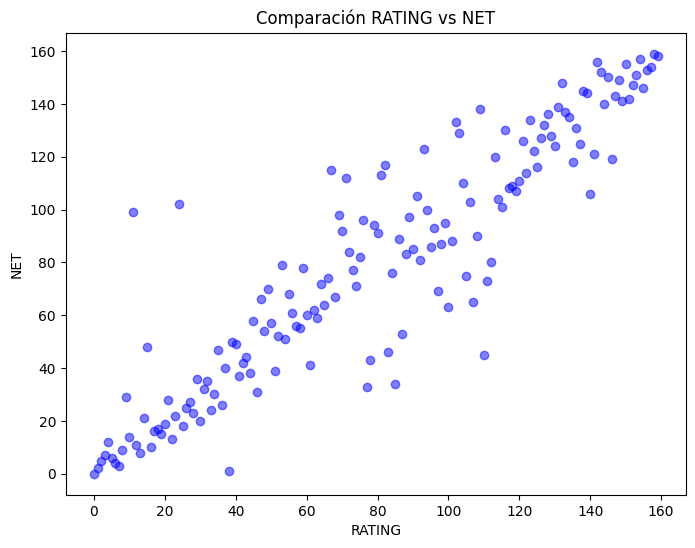

In [14]:
# Se obtiene el orden de aparición de cada uno de los registros
df_quintetos_avanzada_total_grouped = df_quintetos_avanzada_total_grouped.sort_values('RATING',ascending=False).reset_index().drop('index',axis=1)
l_RATING = df_quintetos_avanzada_total_grouped.sort_values('RATING',ascending=False).reset_index()['index']
l_NET = df_quintetos_avanzada_total_grouped.sort_values('NET',ascending=False).reset_index()['index']

# Se calcula las métricas sobre las diferencias entre posiciones
diferencias = np.array(l_RATING) - np.array(l_NET)
media_diferencias = np.mean(diferencias)
desviacion_diferencias = np.std(diferencias)
varianza_diferencias = np.var(diferencias)
moda_diferencias = mode(diferencias)
mediana_diferencias = median(diferencias)

print("##############################################")
print("# MEDIDAS ENTRE LOS RESULTADOS OBTENIDOS")
print("##############################################")
print("Media de las diferencias:", media_diferencias)
print("Desviación estándar de las diferencias:", desviacion_diferencias)
print("Mediana de las diferencias:", mediana_diferencias)
print("Moda de las diferencias:", moda_diferencias)

plt.figure(figsize=(8, 6))  # Tamaño de la figura
plt.scatter(l_RATING, l_NET, color='blue', alpha=0.5)
plt.title('Comparación RATING vs NET')
plt.xlabel('RATING')
plt.ylabel('NET')
plt.grid(False)
plt.show()


Como puede observarse, en la comparativa del *RATING* predicho y el *NET* de cada uno de los quintetos se aprecia que el modelo no está deolviendo la misma ordenación de quintetos lo que los valores predichos por el modelo muestran una nueva forma de clasificar a cada uno de los quintetos. Por otro lado, con respecto a los resultados de la predicción, se puede apreciar como no existe un sobre ajuste de los datos ya que se así la dispersión que se esperaría seria la de una línea totalmente vertical. Además, se puede apreciar que no existen una gran diferencia en los 10 quintetos cuyo NET es más alto con el *RATING* predicho pero si que se pueden encontrar amplias diferencias en a partir del resto de quintetos.

Una vez visto que no existe sobre ajuste sobre los datos, se pasa a realizar la visualización la importancia de cada una de las variables dentro del modelo a la hora de realizar la predicción:

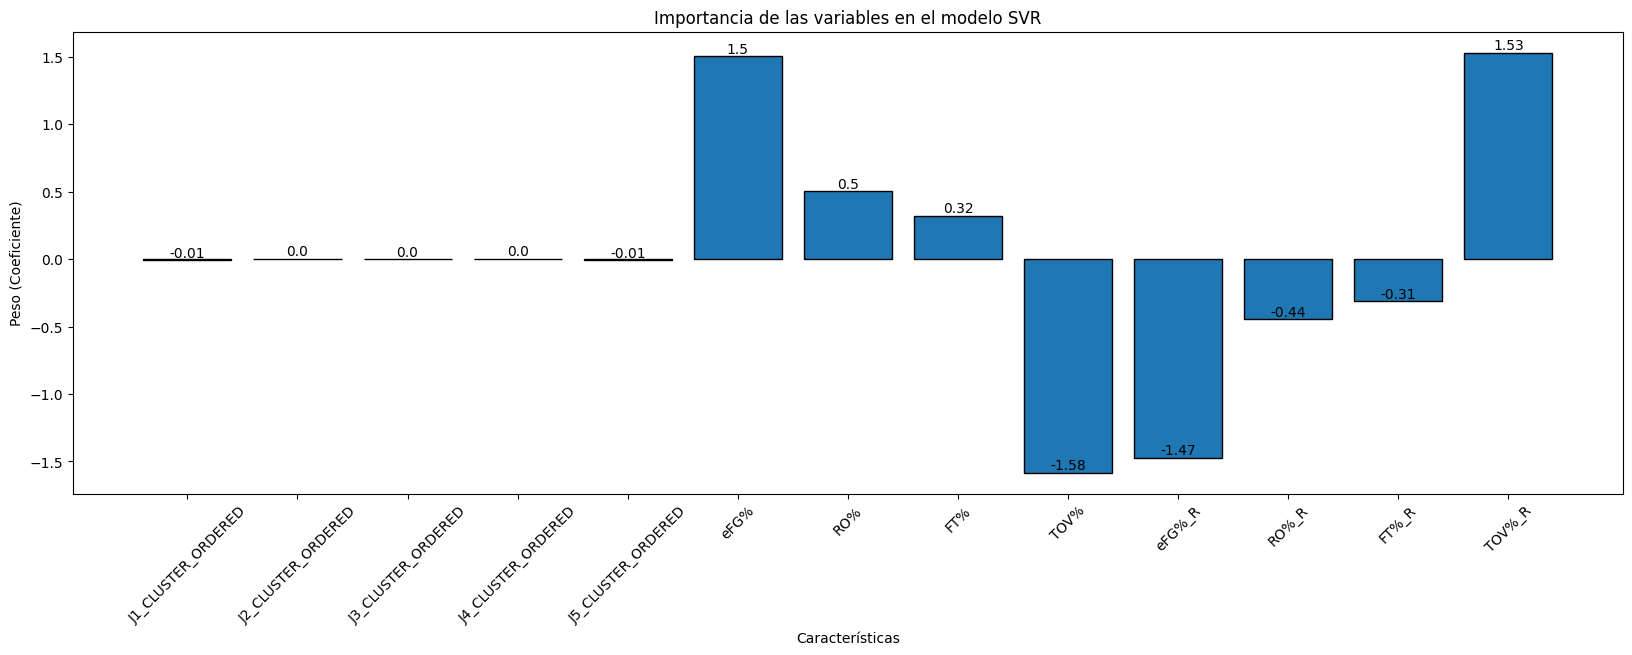

In [15]:
# Selección de coeficientes de cada variable y seleccion de nombres de cada variables
coef = model_SVR.coef_[0]
feature_names = list(df_quintetos_avanzada_total_grouped.drop(['NET', 'RATING'], axis=1).columns)

# Se genera la visualización
plt.figure(figsize=(20, 6))
bars = plt.bar(feature_names, coef, edgecolor='black')
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, yval, round(yval, 2), ha='center', va='bottom', fontsize=10)
for bar in bars:
    bar.set_linewidth(1)
    bar.set_edgecolor('black')
plt.xlabel('Características')
plt.ylabel('Peso (Coeficiente)')
plt.title('Importancia de las variables en el modelo SVR')
plt.xticks(rotation=45)
plt.show()

Siguiendo el gráfico puede observase que las variables están divididas en tres grupos por su importancia:
* *Variable neutras.* Compuestas por las variables que hacen referencia a la posición de los jugadores. La importancia de estas variables es 0 lo cual tiene sentido ya que solo representan la nueva posición del jugador dentro del quinteto.
* *Variables con peso positivo.* Compuestas por las variable eFG%, TOV%_R, RO% y FT%- La importancia de estas variables es positiva lo cual tiene sentido debido a que representan lo bien que lo hizo un quinteto en cuanto a la eficiencia de tiro, volumen de pérdidas del rival, dominancia del rebote ofensivo y verticalidad al aro respectivamente.
* *Variables con peso negativo.* Compuestas por las variables eFG%_R, TOV%, RO%_R y FT%_R lo cual tiene sentido debido a que representan lo bien que lo hizo el quinteto rival en cuanto a su eficiencia en el tiro, el volumen de pérdidas que provocó al quinteto, su dominancia en el rebote ofensivo y su verticalidad al aro respectivamente.

Teniendo presente estos tres tipo de variables, se puede concluir que el modelo creado realiza la predicción del *RATING* siguiendo los estandares lógicos dentro de cada una de los apartados estadísticos, y por lo tanto, tiene sentido con la realidad que se puede encontrar detro de las pistas de baloncesto.

Dicho esto, se pasa a analizar los resultados del modelo teniendo en cuenta las nuevas posiciones con el fin de conocer los mejores quintetos a utilizar dentro de la liga. Para ello, se pasa a visualizar los 50 mejores quintetos:

####################################################
# TOP-50 Mejores quintetos
####################################################


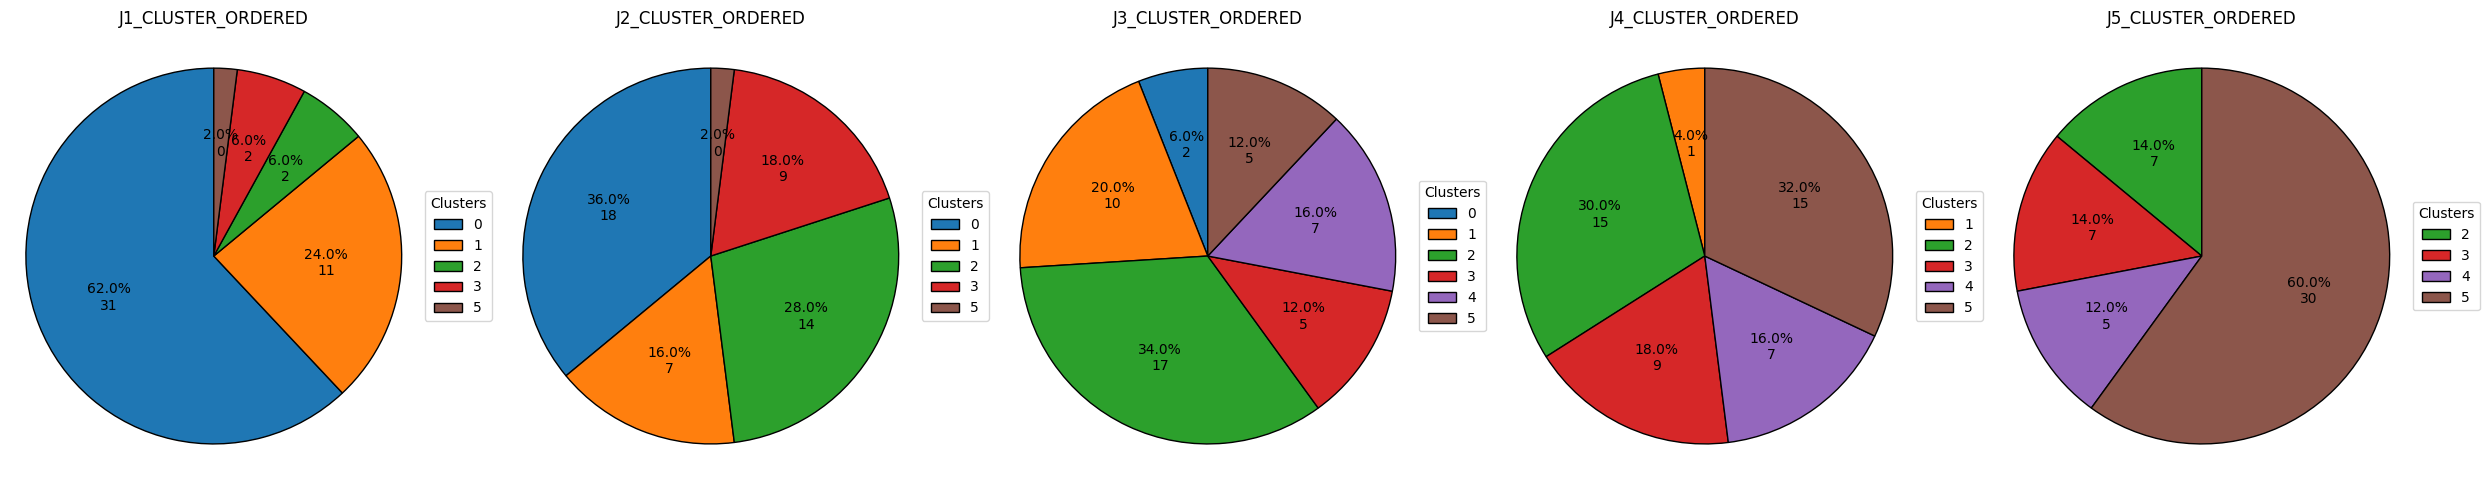

In [18]:
print("####################################################")
print("# TOP-50 Mejores quintetos")
print("####################################################")
df_top_50_mejores = df_quintetos_avanzada_total_grouped.sort_values('RATING',ascending=False).head(50)
# Se genera la visualización por posicion
fig, axes = plt.subplots(1, 5, figsize=(25, 5))  # Asegurar que los subplots se generen horizontalmente
columns = ['J1_CLUSTER_ORDERED', 'J2_CLUSTER_ORDERED', 'J3_CLUSTER_ORDERED', 'J4_CLUSTER_ORDERED', 'J5_CLUSTER_ORDERED']
for i, column in enumerate(columns):
    obtener_visualizacion_quinteto(axes[i], df_top_50_mejores, column)
plt.tight_layout()
plt.show()

Como puede observarse en los 50 mejores quintetos bansandose en el *RATING* calculado por el modelo, existe una clara predominancia de que en todos ellos al meno uno de los jugadores pertenezca al cluster 0, es decir, sea un *Organizador del juego*. Por otro lado, existe también una clara tendencia en los equipos a tener jugadores pertenecientes a los clusters 2 y 5 debido a que estos tipos de jugadores destacan por su capacidad de rebote y su buena puntería desde distintas partes de la línea de tres. Por otro lado, se puede observar como la utilización de jugadores perteneciente al *cluster 5* es muy reducida en los quintetos por lo que no es tan importante tener a un dominador de la pintura, y los jugadores pertenecientes al *cluster 3* lo que hace pensar que no es tan necesario tener a un jugador capaz de organizar y tirar desde la esquina.

Revisados los 25 mejores quintetos según el *RATING* se pasa a realizar la composición de los quintetos más eficientes dentro de la liga la cual se basará en el porcentaje de aparación de cada una de las nuevas posiciones en función del jugador:

In [21]:
print("####################################################")
print("# TOP-5 Mejores quintetos")
print("####################################################")
df_top_10_mejores = df_quintetos_avanzada_total_grouped.sort_values('RATING',ascending=False).head(5)
print("\n",df_top_10_mejores.to_string(index=False, col_space=1))

####################################################
# TOP-5 Mejores quintetos
####################################################

  J1_CLUSTER_ORDERED  J2_CLUSTER_ORDERED  J3_CLUSTER_ORDERED  J4_CLUSTER_ORDERED  J5_CLUSTER_ORDERED   eFG%    RO%    FT%   TOV%  eFG%_R  RO%_R  FT%_R  TOV%_R    NET   RATING
                  0                   2                   2                   2                   2 0.5282 0.3947 0.3803 0.1665  0.4118 0.1818 0.2500  0.1796 0.3330 0.353195
                  1                   2                   5                   5                   5 0.6282 0.5500 0.3333 0.1730  0.4444 0.3667 0.2222  0.1159 0.0427 0.320870
                  0                   3                   3                   5                   5 0.5967 0.3382 0.2164 0.1258  0.4644 0.2928 0.1627  0.1698 0.3143 0.315618
                  1                   2                   4                   5                   5 0.5636 0.3443 0.3273 0.1680  0.5000 0.2258 0.1667  0.2334 0.1932 0.303

Como puede observarse, los mejores quintetos de la liga, son los siguientes:
* Primer mejor quinteto compuesto por un jugador *Organizador del juego* y cuatro *Reboteadores con buen porcentaje de tiro en media y larga distancia frontal* con un *Rating* de 0.353195.
* Segundo mejor quinteto compuesto por un jugador *Tirador frontal*, uno *Reboteador con buen porcentaje de tiro en media y larga distancia* y tres *Reboteadores con capacidad de tirar de tres puntos* con un *Rating* de 0.320870.
* Tercer mejor quinteto compuesto por un jugador *Organizador del juego*, dos *Organizadores especialistas del tiro de esquina* y dos *Reboteadores con capacidad de tirar de tres puntos* con un *Rating* de 0.315618.
* Cuarto mejor quinteto compuesto por un jugador *Tirador frontal*, uno *Reboteador con buen porcentaje de tiro en media y larga distancia*, uno *Dominante de pintura* y dos *Reboteadores con capacidad de tirar de tres puntos* con un *Rating* de 0.303222.
* Quinteto mejor quinteto compuesto por un jugador *Organizador del juego*, dos *Reboteadores con buen porcentaje de tiro en media y larga distancia frontal*, uno *Dominante de pintura* y uno *Reboteador con capacidad de tirar de tres puntos* con un *Rating* de 0.280745.